# Instrument Response
We need to sort out how exactly to calculate the instrument response function. We want to look at the Hi-C 193 and the AIA 193 channels, look at their differences,  and then use the AIA 171 channel to approximate the Hi-C 171 channel.

In [1]:
import numpy as np
from scipy.interpolate import splrep,splev
import scipy.signal
import matplotlib.pyplot as plt
import astropy.units as u
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentBase
from synthesizAR.atomic import EmissionModel
from synthesizAR.util import SpatialPair
from astropy.coordinates import SkyCoord

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
aia = InstrumentSDOAIA([0,1]*u.s,SkyCoord(lon=0*u.deg,lat=0*u.deg,frame='heliographic_stonyhurst'))

In [3]:
with open('HiC_193.ins','r') as f:
    lines = f.readlines()
    n = int(lines[0])
    wvl_193_tmp = np.zeros((n,))
    resp_hi_c_193 = np.zeros((n,))
    for i,l in enumerate(lines[1:n+1]):
        wvl_193_tmp[i] = l.strip().split()[0]
        resp_hi_c_193[i] = l.strip().split()[1]

In [4]:
delta_lambda=10
wvl_193 = 193 + np.linspace(-delta_lambda,delta_lambda,1000)
wvl_171 = 171 + np.linspace(-delta_lambda,delta_lambda,1000)

In [5]:
resp_hi_c_193 = splev(wvl_193,splrep(wvl_193_tmp,resp_hi_c_193))
resp_aia_193 = splev(wvl_193,aia.channels[3]['wavelength_response_spline'])
resp_aia_171 = splev(wvl_171,aia.channels[2]['wavelength_response_spline'])

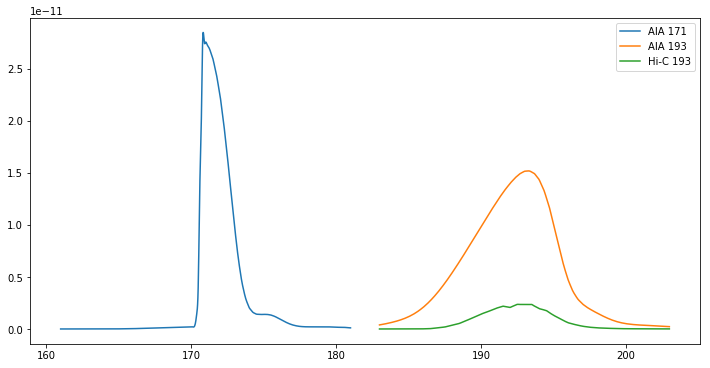

In [6]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
ax.plot(wvl_171,resp_aia_171,label='AIA 171')
ax.plot(wvl_193,resp_aia_193,label='AIA 193')
ax.plot(wvl_193,resp_hi_c_193,label='Hi-C 193')
#ax.set_yscale('log')
plt.legend()

In [7]:
scaling_factor = resp_hi_c_193 / resp_aia_193

In [8]:
resp_hi_c_171 = resp_aia_171 * scaling_factor

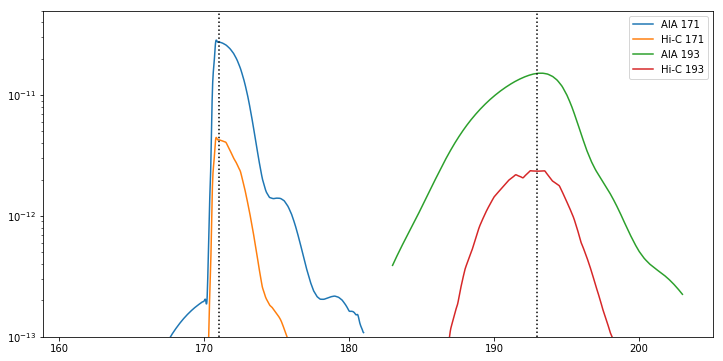

In [9]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
ax.plot(wvl_171,resp_aia_171,label='AIA 171')
ax.plot(wvl_171,resp_hi_c_171,label='Hi-C 171')
ax.plot(wvl_193,resp_aia_193,label='AIA 193')
ax.plot(wvl_193,resp_hi_c_193,label='Hi-C 193')
ax.set_yscale('log')
ax.set_ylim(1e-13,5e-11)
ax.axvline(x=193,ls=':',color='k')
ax.axvline(x=171,ls=':',color='k')
plt.legend()

In [10]:
em_model = EmissionModel.restore('/storage-home/w/wtb2/data/hi_c_simulation/emission_model.json')

In [13]:
em_model[0].transitions.wavelength

<Quantity [5.446600e+04, 2.556840e+02, 2.551100e+02, ..., 6.431489e+03,
           6.462871e+03, 6.410260e+05] Angstrom>

In [29]:
len(em_model._ion_list)

18

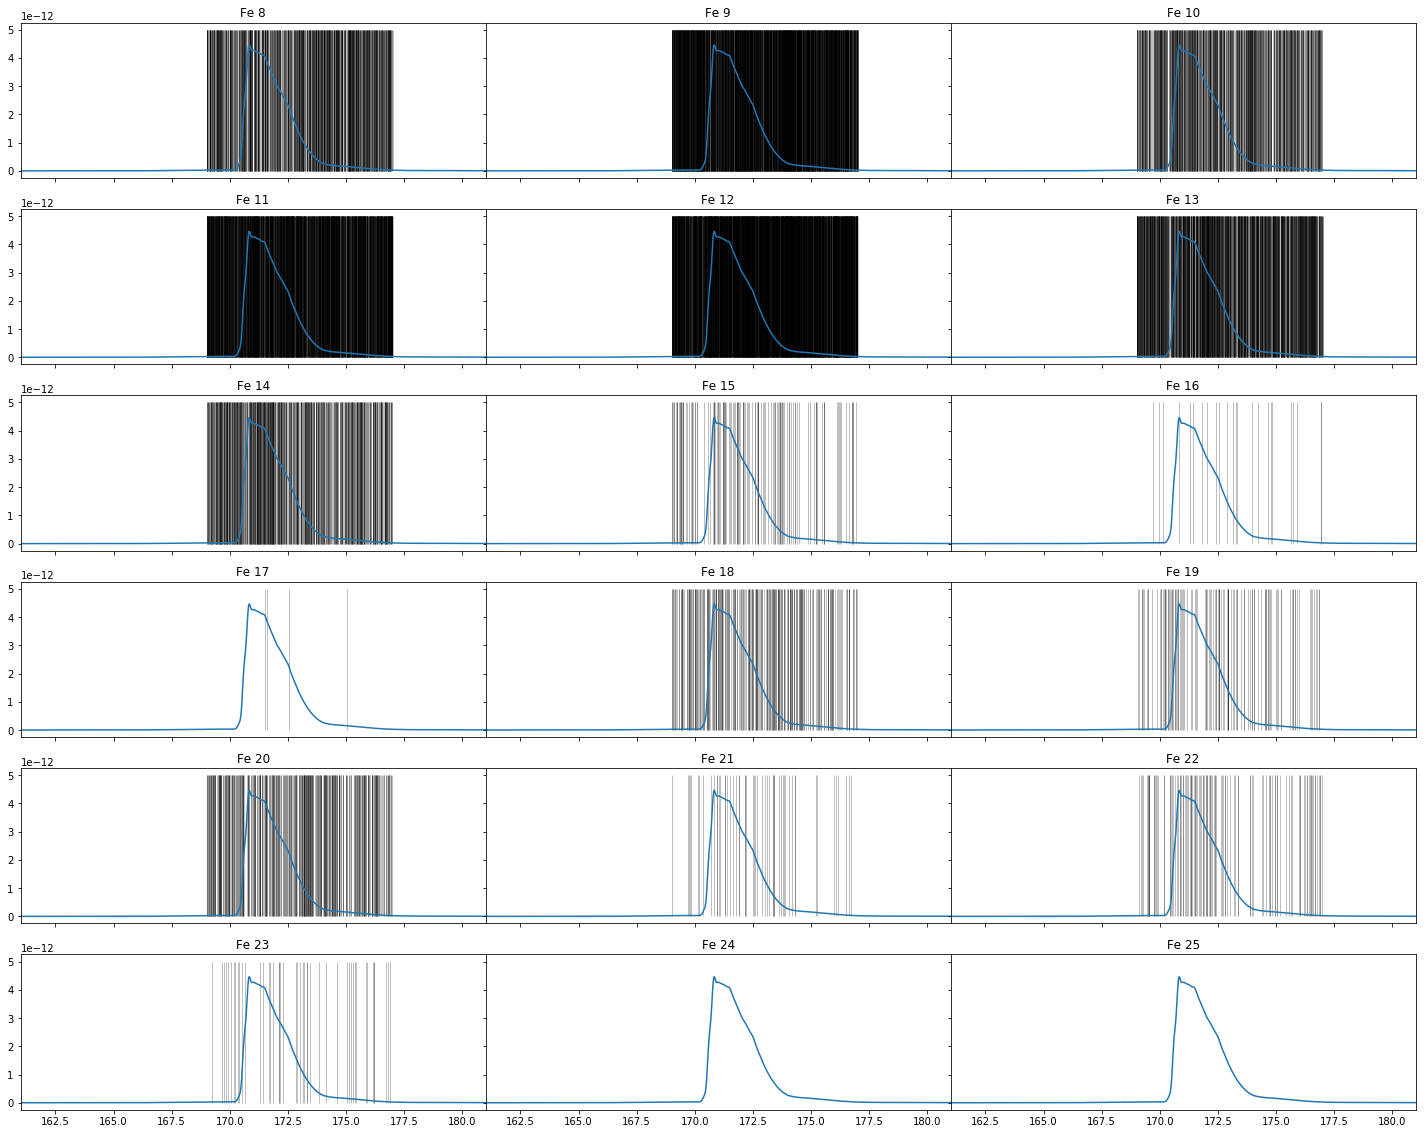

In [33]:
fig,axes = plt.subplots(6,3,figsize=(25,20),sharex=True,sharey=True)
for i,ion in enumerate(em_model):
    ax = axes.flatten()[i]
    ax.set_title(f'{ion.ion_name}')
    ax.plot(wvl_171,resp_hi_c_171)
    i_env = np.where(np.logical_and(ion.transitions.wavelength.value >= 169,
                                    ion.transitions.wavelength.value <= 177))
    ax.vlines(ion.transitions.wavelength[i_env],0,5e-12,color='k',lw=0.5,alpha=0.5)
    ax.set_xlim(wvl_171[0],wvl_171[-1])
plt.subplots_adjust(wspace=0.)

Alternatively, try to derive a transformation between the two.

In [70]:
aia_193_norm = aia_193_resp#(aia_193_resp - aia_193_resp.mean()) / aia_193_resp.std()
hi_c_193_norm = hi_c_193_resp#(hi_c_193_resp - hi_c_193_resp.mean()) / hi_c_193_resp.std()

In [71]:
filter_aia_to_hic = np.outer(hi_c_193_norm,1./aia_193_norm)

In [72]:
hi_c_171_resp = np.dot(filter_aia_to_hic, aia_171_resp)#(aia_171_resp - aia_171_resp.mean())/aia_171_resp.std())

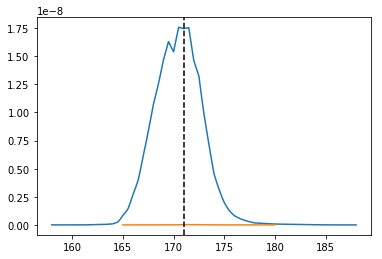

In [75]:
plt.plot(hi_c_193_wvl - 22,hi_c_171_resp)
plt.plot(aia_171_wvl,aia_171_resp)
#plt.plot(hi_c_193_wvl,)
plt.axvline(x=171,ls='--',color='k')

In [33]:
aia_to_hi_c_filter,aia_to_hi_c_remainder = scipy.signal.deconvolve(hi_c_193_resp,aia_193_resp,)

In [38]:
hi_c_171_resp = scipy.signal.convolve(aia_171_resp,aia_to_hi_c_filter) #+ aia_to_hi_c_remainder 

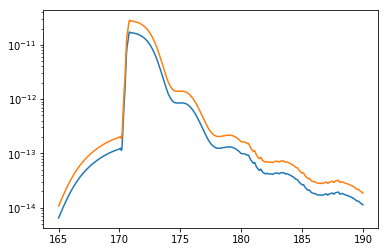

In [41]:
plt.plot(w,110*hi_c_171_resp)
plt.plot(w,aia_171_resp)
plt.yscale('log')

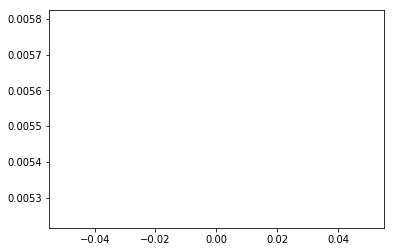

In [42]:
plt.plot(aia_to_hi_c_filter)

## Building the Hi-C Instrument

In [ ]:
class InstrumentHiC(InstrumentBase):
    """
    High Resolution Coronal Imager (Hi-C) instrument
    """
    
    def __init__(self, observing_time, observer_coordinate):
        self.fits_template['telescop'] = 'HiC'
        self.fits_template['detector'] = 'HiC'
        self.fits_template['waveunit'] = 'angstrom'
        self.name = 'Hi_C'
        self.channels = [{'wavelength': 171*u.angstrom,
                          'gaussian_width': {'x': 0.962*u.pixel, 'y': 0.962*u.pixel}},]
        self.cadence = 6.0*u.s
        self.resolution = SpatialPair(x=0.1*u.arcsec/u.pixel, y=0.1*u.arcsec/u.pixel, z=None)
        self.apply_psf = apply_psf
        super().__init__(observing_time, observer_coordinate)
        self._setup_channels()
        
    def _setup_channels(self,):
        """
        Configure the wavelength response function of the instrument
        """
        pass
    
    def build_detector_file(self, file_template, dset_shape, chunks, *args, parallel=False):
        """
        Allocate space for counts data.
        """
        additional_fields = ['{}'.format(channel['name']) for channel in self.channels]
        super().build_detector_file(file_template, dset_shape, chunks, *args,
                                    additional_fields=additional_fields, parallel=parallel)
    
    def flatten_parallel(self, loops, interpolated_loop_coordinates, tmp_dir, emission_model=None):
        """
        """
        pass
    
    def calculate_counts(self,):
        pass
    
    def detect(self, channel, i_time, header, bins, bin_range):
        """
        For a given timestep, map the intensity along the loop to the 3D field and
        return the Hi-C data product.

        Parameters
        ----------
        channel : `dict`
        i_time : `int`
        header : `~sunpy.util.metadata.MetaDict`
        bins : `~synthesizAR.util.SpatialPair`
        bin_range : `~synthesizAR.util.SpatialPair`

        Returns
        -------
        AIA data product : `~sunpy.map.Map`
        """
        with h5py.File(self.counts_file, 'r') as hf:
            weights = np.array(hf[channel['name']][i_time, :])
            units = u.Unit(hf[channel['name']].attrs['units'])

        hpc_coordinates = self.total_coordinates
        dz = np.diff(bin_range.z)[0].cgs / bins.z * (1. * u.pixel)
        visible = is_visible(hpc_coordinates, self.observer_coordinate)
        hist, _, _ = np.histogram2d(hpc_coordinates.Tx.value, hpc_coordinates.Ty.value,
                                    bins=(bins.x.value, bins.y.value),
                                    range=(bin_range.x.value, bin_range.y.value),
                                    weights=visible * weights * dz.value)
        header['bunit'] = (units * dz.unit).to_string()

        counts = gaussian_filter(hist.T, (channel['gaussian_width']['y'].value,
                                          channel['gaussian_width']['x'].value))
        return Map(counts, header)